In [2]:
import skxray.speckle_analysis as spe_vis
import skxray.roi as roi
import skxray.correlation as corr
import skxray.core as core

import numpy as np
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/duke_cc_12C/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data=np.asarray(duke_data)



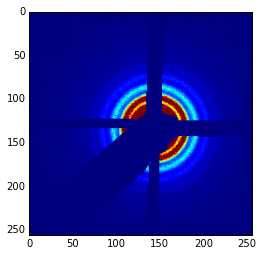

In [4]:
avg_img = np.average(duke_data, axis=0)

mask4 = np.load("/Users/sameera/Desktop/XSVS/new_mask4.npy")
#mask5 = ~np.loa/Users/sameera/Desktop/XSVS/Luxi_datad("/Users/sameera/Desktop/XSVS/new_mask5.npy")
mask = np.load("/Users/sameera/Desktop/XSVS/Luxi_data/Luxi_duke_mask.npy")

N_mask = ~(mask + mask4)

plt.imshow(N_mask*avg_img, vmax=1e0)
plt.show()

In [5]:
inner_radius = 24
width = 1
spacing = 1
num_rings = 10
center = (133, 143)

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, center, avg_img.shape)


In [6]:
mask_data2 = N_mask*duke_data[0:4999]

ring_mask = rings*N_mask

In [7]:
num_levels = 7
num_bufs = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, ring_mask,
                                             mask_data2)

In [8]:
exposuretime=0.001;
deadtime=60e-6;
timeperframe = exposuretime+deadtime
lags = lag_steps*timeperframe

roi_names = ['gray', 'orange', 'brown', 'red', 'green', 'blue', 'black', 'purple', 'pink', 'yellow']

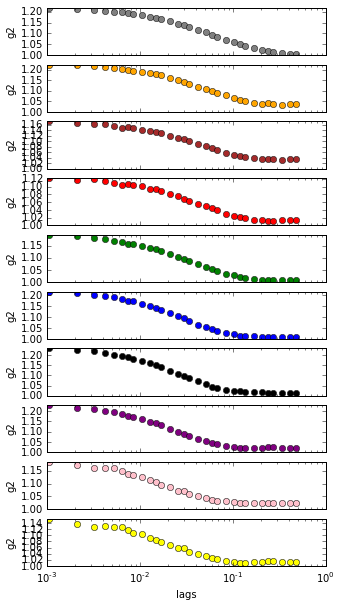

In [9]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].semilogx(lags, g2[:, i], 'o', markerfacecolor=roi_color, markersize=6)
    axes[i].set_ylim(bottom=1, top=np.max(g2[1:, i]))
plt.show()

In [10]:
def auto_corr_scat_factor(lags, beta, relatxation_rate, basline=1):
    """
    This will returns normalized intensity-intensity time correlation data to be
    minimized

    Parameters
    ----------
    lags : array
        delay time

    beta : float
        optical contrast (speckle contrast), a sample-independent
        beamline parameter

    relatxation_rate : float
        relaxation time associated with the samples dynamics.

    basline : float, optional
        baseline of one time correlation
        equal to one for ergodic samples

    Returns
    -------
    g2 : array
        normalized intensity-intensity time autocorreltion

    Note :
    The intensity-intensity autocorrelation g2 is connected to the intermediate
    scattering factor(ISF) g1

    :math ::
        g2(q, t) = \\beta[g1(q, t)]^{2} + g_\\infty

    For a system undergoing  diffusive dynamics,

    :math ::
        g1(q, t) = e^{-\\Gamma t}

    :math ::
        g2(q, t) = \\beta e^{-2\\Gamma t} + g_\\infty

    These implementation are based on published work. [1]_

     References
    ----------

    .. [1] L. Li, P. Kwasniewski, D. Orsi, L. Wiegart, L. Cristofolini, C. Caronna
       and A. Fluerasu, " Photon statistics and speckle visibility spectroscopy with
       partially coherent X-rays," J. Synchrotron Rad. vol 21, p 1288-1295, 2014

    """
    return beta*np.exp(-2*relatxation_rate*lags) + 1


def residual_auto_corr(params, lags, g2_data, eps_data):
    """
    Parameters
    ----------
    params : dict or
        parameters dictionary
        {beta (float, optical contrast (speckle contrast),
         relatxation_rate(float, relaxation time associated with the
        samples dynamics,
        basline(float, optional baseline of one time
        correlation equal to one for ergodic samples)}

    lags : array
        delay time

    g2_data : array
        normalized intensity-intensity time autocorreltion

    eps_data : float

    Returns
    -------
    residual : array
        difference between experimental result and the model

    fit_result : array
        best fit to the experimental data

    """
    # create set of parameters
    beta = params['beta'].value
    relaxation_rate = params['relaxation_rate'].value
    baseline = params['baseline'].value

    return (g2_data - auto_corr_scat_factor(lags, beta, relaxation_rate,
                                            basline=1))/eps_data


def fit_auto_corr(params, x, data, eps_data):
    """
    Parameters
    ----------
    params: dict
        parameters dictionary

    x : array
       x

    data : array

    eps_data : array

    Returns
    -------
    fit_result :

    """
    result = minimize(residual_auto_corr, params, args=(x, data, eps_data))
    
    return data + result.residual

In [16]:
from lmfit import minimize, Parameters
# create a set of Parameters
params = Parameters()
params.add('beta',  value=0.2, min=0, max=0.25)
params.add('relaxation_rate', value=10, min=0, max=11)
params.add('baseline', value=1)


In [17]:
fit_result = fit_auto_corr(params, lags, g2[:, 0], eps_data=1)

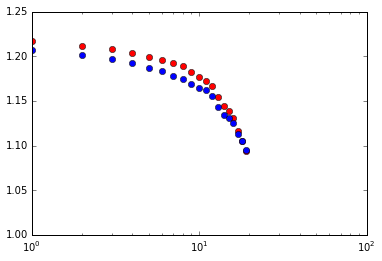

In [27]:
plt.semilogx(g2[:,0][:20], 'ro')
plt.semilogx(fit_result[:20], 'bo')
plt.ylim(1.0, 1.25)
plt.show()

In [106]:
final_result = fit_auto_corr(params, lags, g2[:, 0], eps_data=1)

In [108]:
final_result

array([ 1.50926854,  1.2066141 ,  1.20100078,  1.19723139,  1.19229231,
        1.18694966,  1.18357905,  1.17850784,  1.17516615,  1.16909419,
        1.16499456,  1.16214561,  1.1561685 ,  1.1433808 ,  1.13405591,
        1.1312723 ,  1.12496068,  1.11324955,  1.10548597,  1.09535069,
        1.09018936,  1.07981957,  1.07273023,  1.06532261,  1.06071072,
        1.04877835,  1.04171505,  1.03389148,  1.0260495 ,  1.01615149,
        1.00925438,  1.01149083])

In [21]:
final_result2 = corr.fit_auto_corr(params, lags, g2[:,3], eps_data=1)

In [23]:
final_result2, g2[:,3]

(array([ 4.024407  ,  0.99925773,  0.99610826,  1.00823892,  0.99907207,
         0.99634915,  0.99338211,  1.00355113,  1.00329376,  1.00271139,
         0.99786404,  1.00554502,  1.00724801,  1.00451235,  1.00725061,
         1.00376521,  1.00841639,  1.01277845,  1.01909794,  1.02009237,
         1.02162793,  1.02278932,  1.02394465,  1.02425158,  1.02497658,
         1.02475019,  1.02315852,  1.02319362,  1.0231285 ,  1.02688023,
         1.02611404,  1.02649167]),
 array([ 2.6372035 ,  1.12174759,  1.11735799,  1.12067335,  1.11340333,
         1.10941721,  1.10536953,  1.10794897,  1.10537298,  1.10035508,
         1.0934201 ,  1.09295486,  1.08969683,  1.08066321,  1.07504929,
         1.06694545,  1.06347644,  1.05557054,  1.05036005,  1.04391158,
         1.03891577,  1.03074507,  1.02529668,  1.02130071,  1.01880598,
         1.0153706 ,  1.01299957,  1.01227024,  1.01188356,  1.0135119 ,
         1.01307316,  1.01324946]))